In [1]:
import os
os.chdir('/Users/yinancheng/Documents/Project/TrustworthyAI/Advertisement/')

import pandas as pd

path = 'Data/nonpotential_label'
result_path = 'Result/nonpotential_label'
df_train = pd.read_csv(f'{path}/df_train.csv')
df_syn_ctgan = pd.read_csv(f'{path}/df_syn_ctgan.csv')
df_syn_ctabgan = pd.read_csv(f'{path}/df_syn_ctabgan.csv')
df_syn_tvae = pd.read_csv(f'{path}/df_syn_tvae.csv')
df_syn_ds = pd.read_csv(f'{path}/df_syn_ds.csv')
#df_syn_great = pd.read_csv(f'{path}/df_syn_great.csv')
df_syn_tabula = pd.read_csv(f'{path}/df_syn_tabula.csv')
df_syn_tabddpm = pd.read_csv(f'{path}/df_syn_tabddpm.csv')
df_holdout = pd.read_csv(f'{path}/df_holdout.csv')
df_val = pd.read_csv(f'{path}/df_val.csv')
print("data is loaded...")

data is loaded...


In [2]:
df_syn_tabula = df_syn_tabula[df_train.columns]
df_syn_tabddpm = df_syn_tabddpm[df_train.columns]

In [3]:
from Dataset_Utility import utility_functions as uf
uf.calculate_label_rate2(df_train, 'label')
uf.calculate_label_rate2(df_syn_ctgan, 'label')
uf.calculate_label_rate2(df_syn_ctabgan, 'label')
uf.calculate_label_rate2(df_syn_tvae, 'label')
uf.calculate_label_rate2(df_syn_ds, 'label')
uf.calculate_label_rate2(df_syn_tabula, 'label')
uf.calculate_label_rate2(df_syn_tabddpm, 'label')
uf.calculate_label_rate2(df_holdout, 'label')
uf.calculate_label_rate2(df_val, 'label')

Total Sample size is 19999, Positive Sample size is 1398, Negative Sample size is 18601, label rate is 0.07515724961023601
Total Sample size is 19999, Positive Sample size is 885, Negative Sample size is 19114, label rate is 0.04630114052526944
Total Sample size is 19999, Positive Sample size is 4683, Negative Sample size is 15316, label rate is 0.30575868372943327
Total Sample size is 19999, Positive Sample size is 6, Negative Sample size is 19993, label rate is 0.000300105036762867
Total Sample size is 19999, Positive Sample size is 1358, Negative Sample size is 18641, label rate is 0.07285016898235074
Total Sample size is 19999, Positive Sample size is 741, Negative Sample size is 19258, label rate is 0.03847751583757399
Total Sample size is 19999, Positive Sample size is 1682, Negative Sample size is 18317, label rate is 0.09182726429000382
Total Sample size is 19999, Positive Sample size is 1398, Negative Sample size is 18601, label rate is 0.07515724961023601
Total Sample size is

In [4]:
# Dictionary of samples
samples = {
    'Training': df_train,
    'Holdout': df_holdout,
    'CTGAN': df_syn_ctgan,
    'CTABGAN': df_syn_ctabgan,
    'TVAE': df_syn_tvae,
    'DS': df_syn_ds,
    #'GReaT': df_syn_great,
    'Tabula': df_syn_tabula,
    'TabDDPM': df_syn_tabddpm
}

In [5]:
for name, sample in samples.items():
    globals()[f'X_{name}'] = sample.drop('label', axis=1) # Predictors
    globals()[f'y_{name}'] = sample['label'] # Response

X_val = df_val.drop('label', axis=1) # Predictors of valide
y_val = df_val['label'] # Response of valid

In [6]:
features = [f"F{i}" for i in range(X_Training.shape[1])]

In [7]:
pd.DataFrame({'Feature':features, 'Name':X_Training.columns})

,Feature,Name
0,F0,u_phonePrice
1,F1,u_browserLifeCycle
2,F2,u_browserMode
3,F3,u_feedLifeCycle
4,F4,u_refreshTimes
5,F5,i_regionEntity
6,F6,i_cat
7,F7,i_dislikeTimes
8,F8,i_upTimes
9,F9,i_dtype


# Feature Importance

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.inspection import permutation_importance
import shap

for sample in samples.keys():
    X_train = globals()[f'X_{sample}']
    y_train = globals()[f'y_{sample}']
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_val)
       
    #Random Forest
    RF = RandomForestClassifier(random_state=0)
    RF.fit(X_train, y_train)
    rf_imp = RF.feature_importances_
    globals()[f'rf_imp_{sample}'] = rf_imp
    
    per_imp = permutation_importance(RF, X_test, y_val, n_repeats=30, random_state=0)
    globals()[f'per_imp_{sample}_rf'] = per_imp
    
    #explainer = shap.Explainer(RF)
    #shap_values = explainer(X_test)[:,:,1]
    #globals()[f'shap_imp_{sample}_rf'] = shap_values
    
    #XGBoost
    XGB = XGBClassifier()
    XGB.fit(X_train, y_train)
    xgb_imp = XGB.feature_importances_
    globals()[f'xgb_imp_{sample}'] = xgb_imp
    
    per_imp = permutation_importance(XGB, X_test, y_val, n_repeats=30, random_state=0)
    globals()[f'per_imp_{sample}_xgb'] = per_imp
    
    explainer = shap.Explainer(XGB)
    shap_values = explainer(X_test)
    globals()[f'shap_imp_{sample}_xgb'] = shap_values
    

## Random Forest Feature Importance

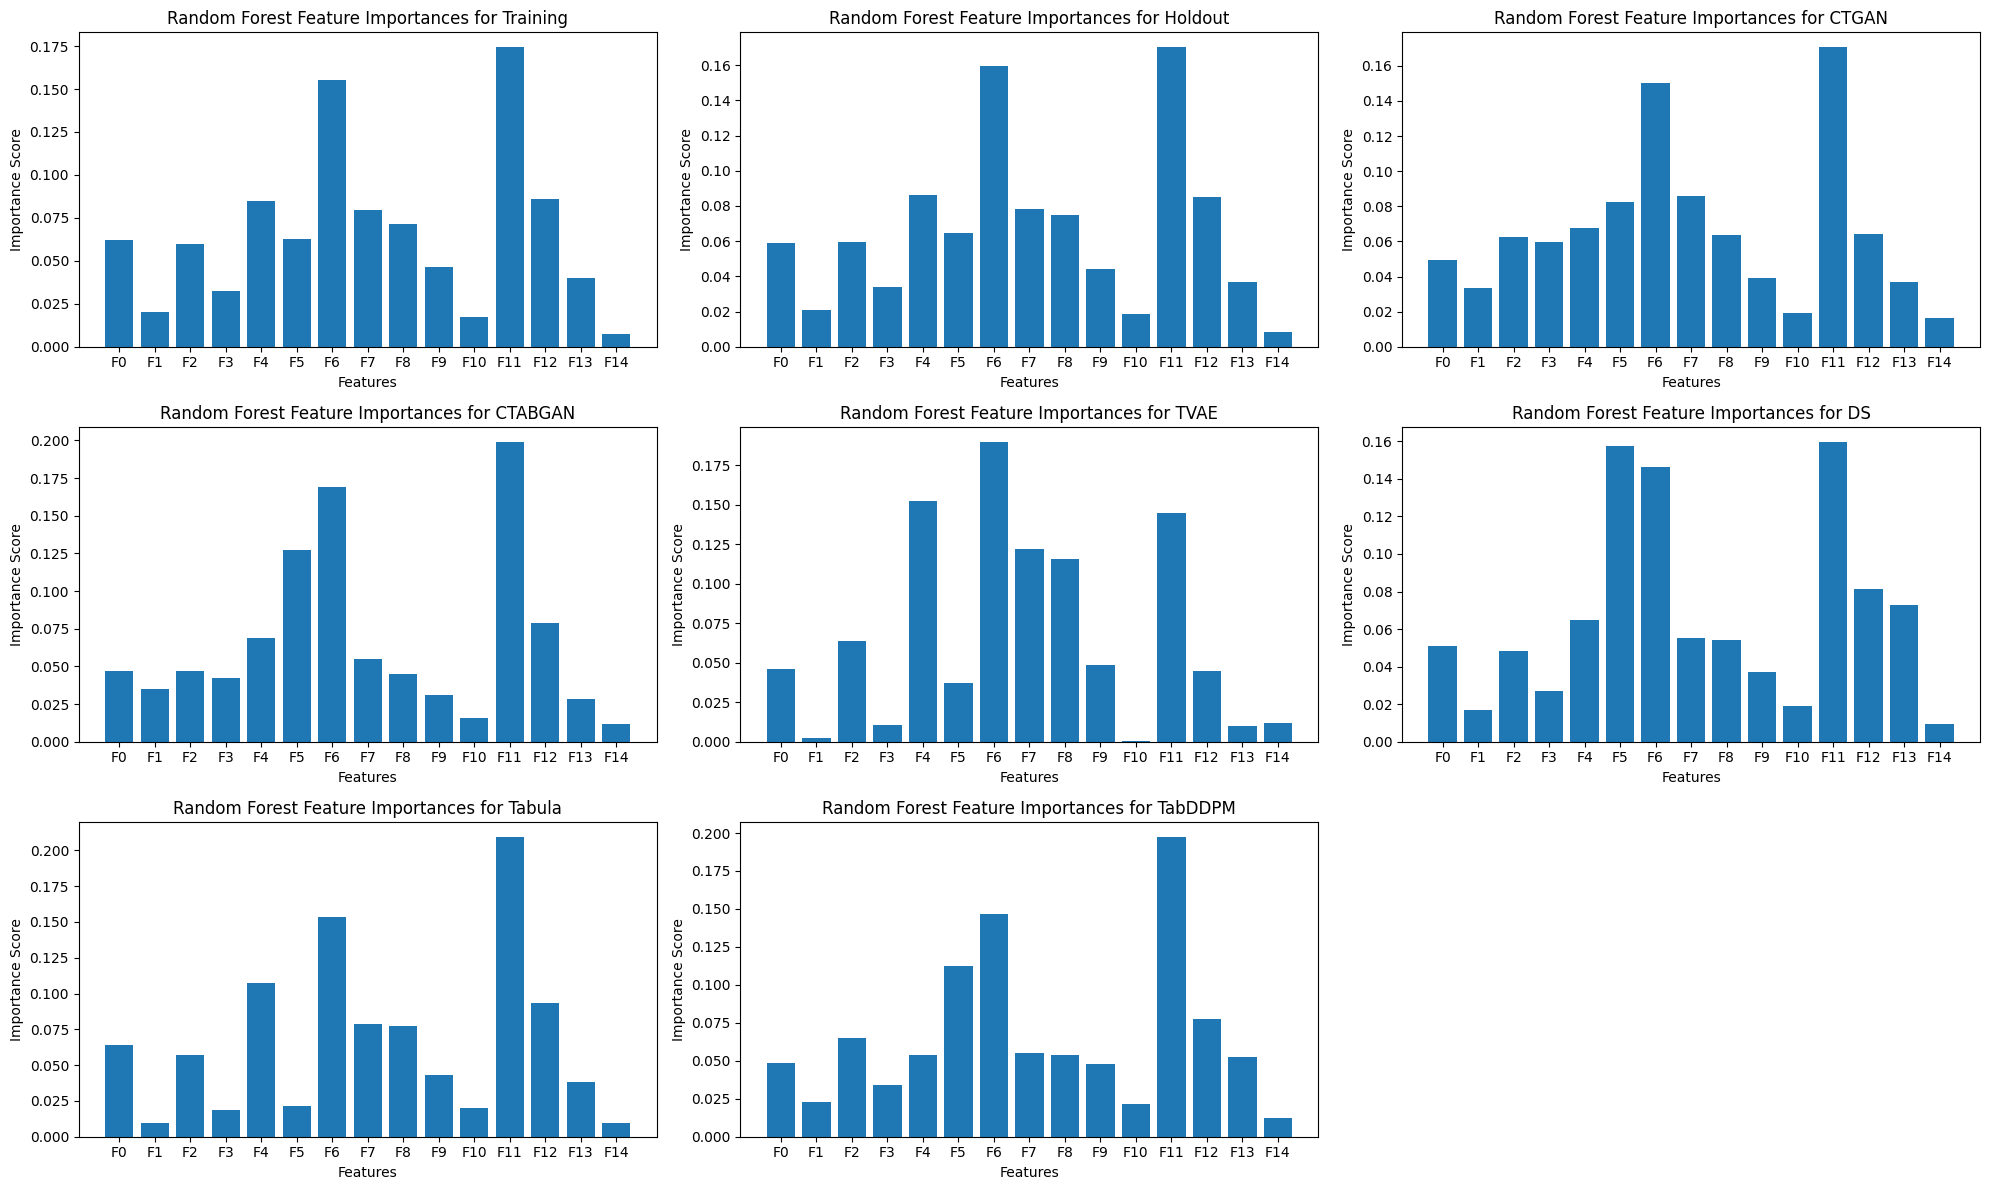

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(20, 12))
ax = ax.flatten()
for i, sample in enumerate(samples.keys()):
    importances = globals()[f'rf_imp_{sample}']
    ax[i].bar(features, importances)
    ax[i].set_title(f"Random Forest Feature Importances for {sample}")
    ax[i].set_xlabel("Features")
    ax[i].set_ylabel("Importance Score")
    
for j in range(len(samples.keys()), len(ax)):
    fig.delaxes(ax[j])
        
plt.tight_layout()
plt.show()
plt.close()

## XGBoost Feature Importance

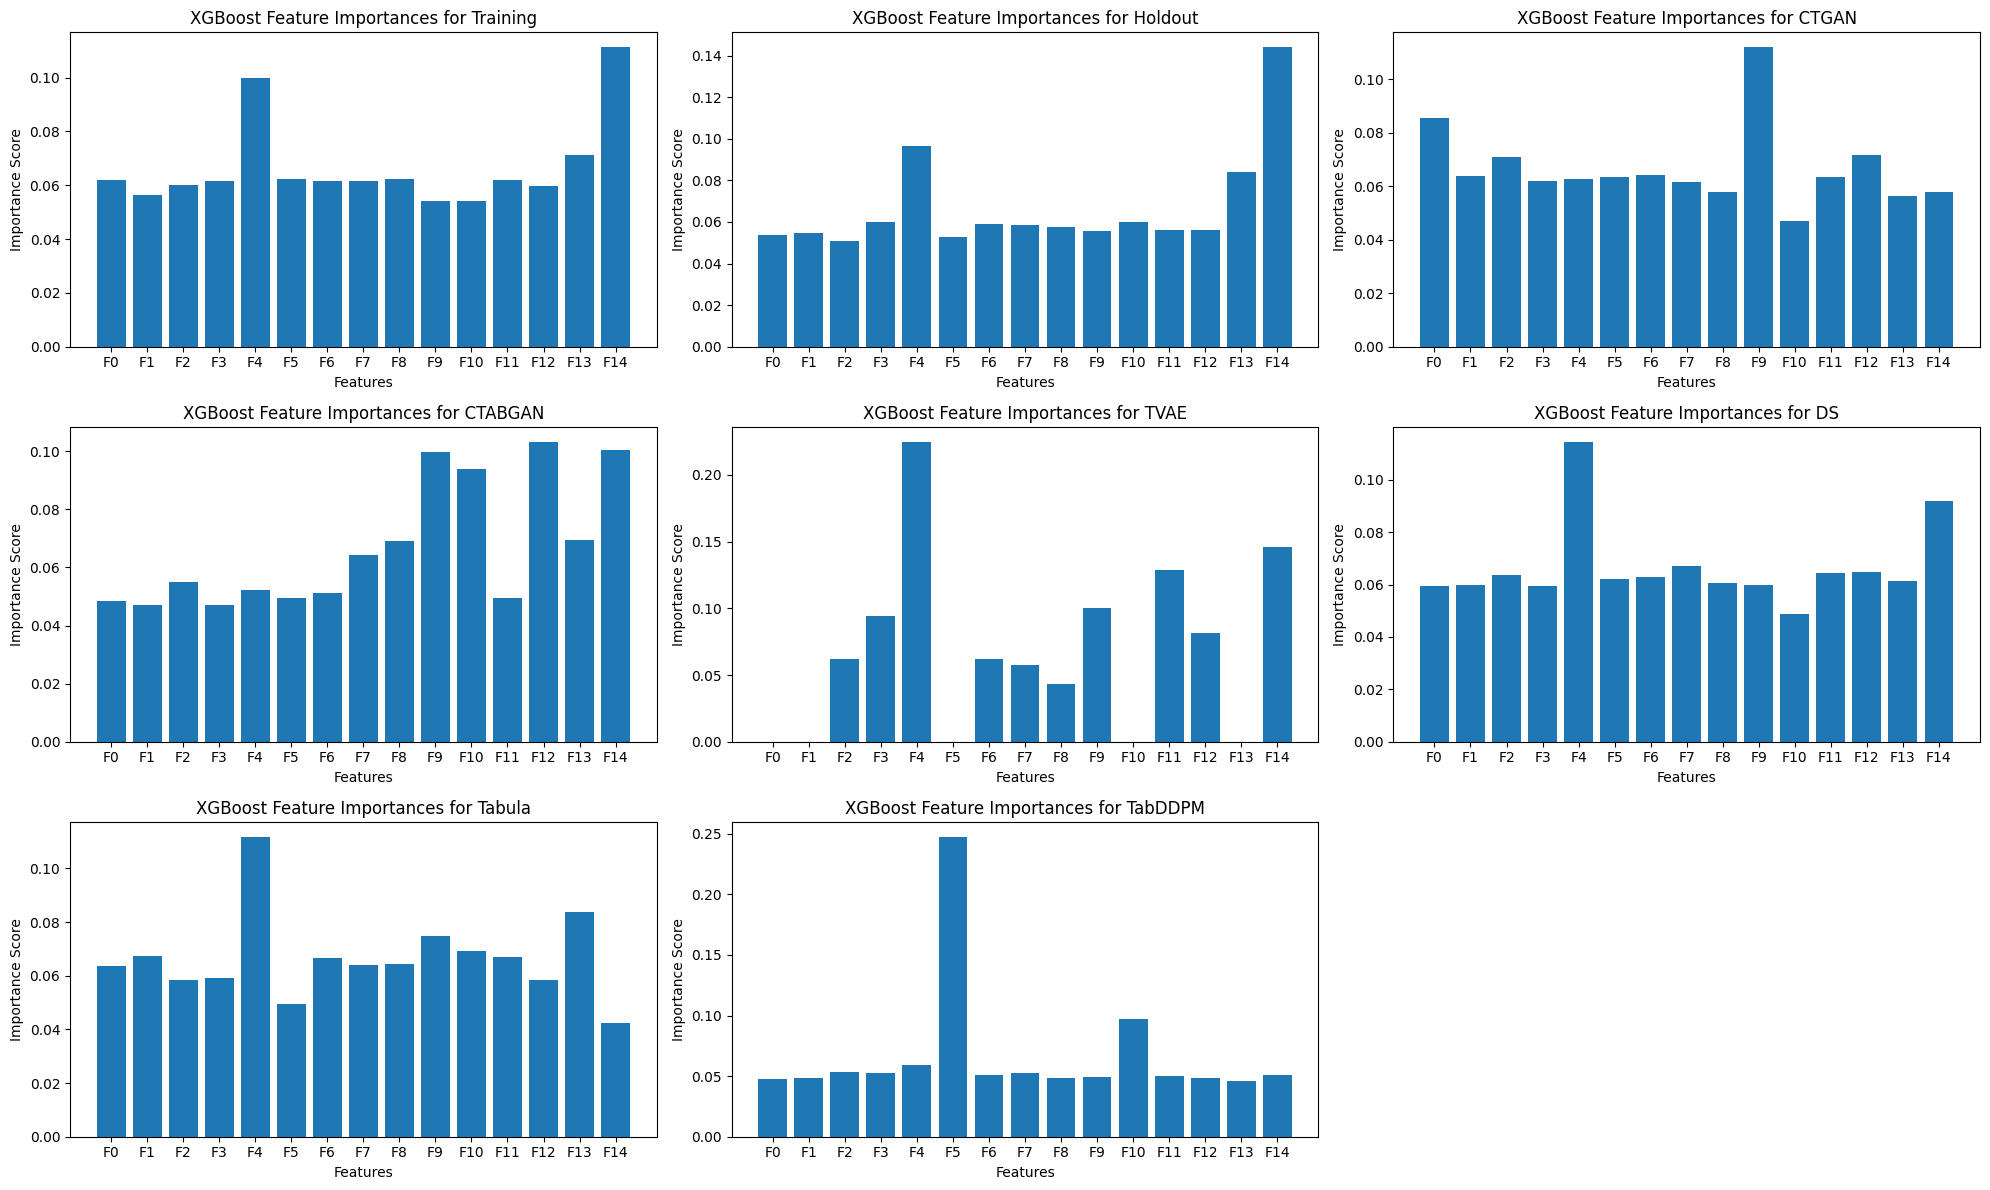

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
ax = ax.flatten()
for i, sample in enumerate(samples.keys()):
    importances = globals()[f'xgb_imp_{sample}']
    ax[i].bar(features, importances)
    ax[i].set_title(f"XGBoost Feature Importances for {sample}")
    ax[i].set_xlabel("Features")
    ax[i].set_ylabel("Importance Score")
    
for j in range(len(samples.keys()), len(ax)):
    fig.delaxes(ax[j])
        
plt.tight_layout()
plt.show()
plt.close()

## Permutation Feature Importance 

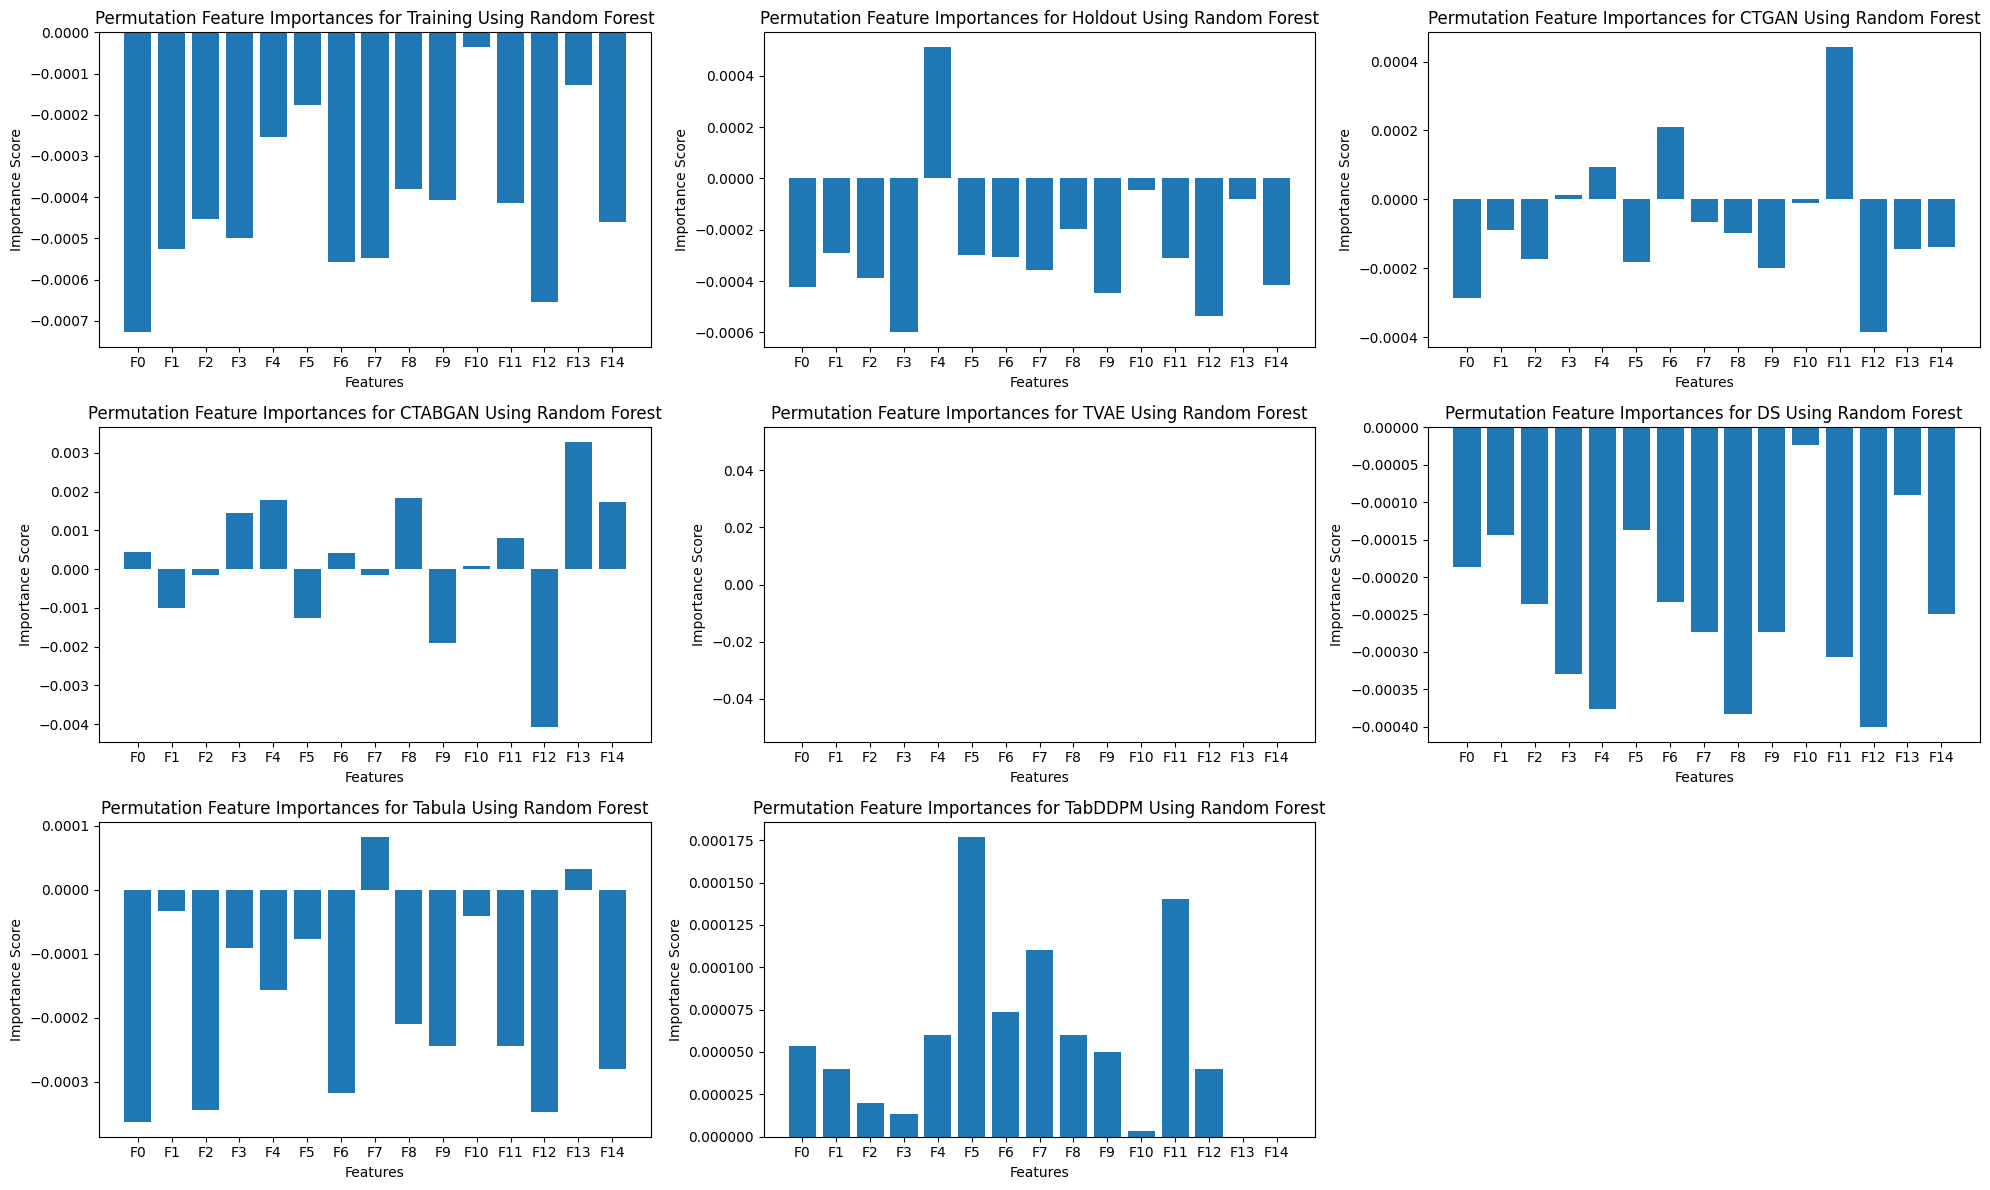

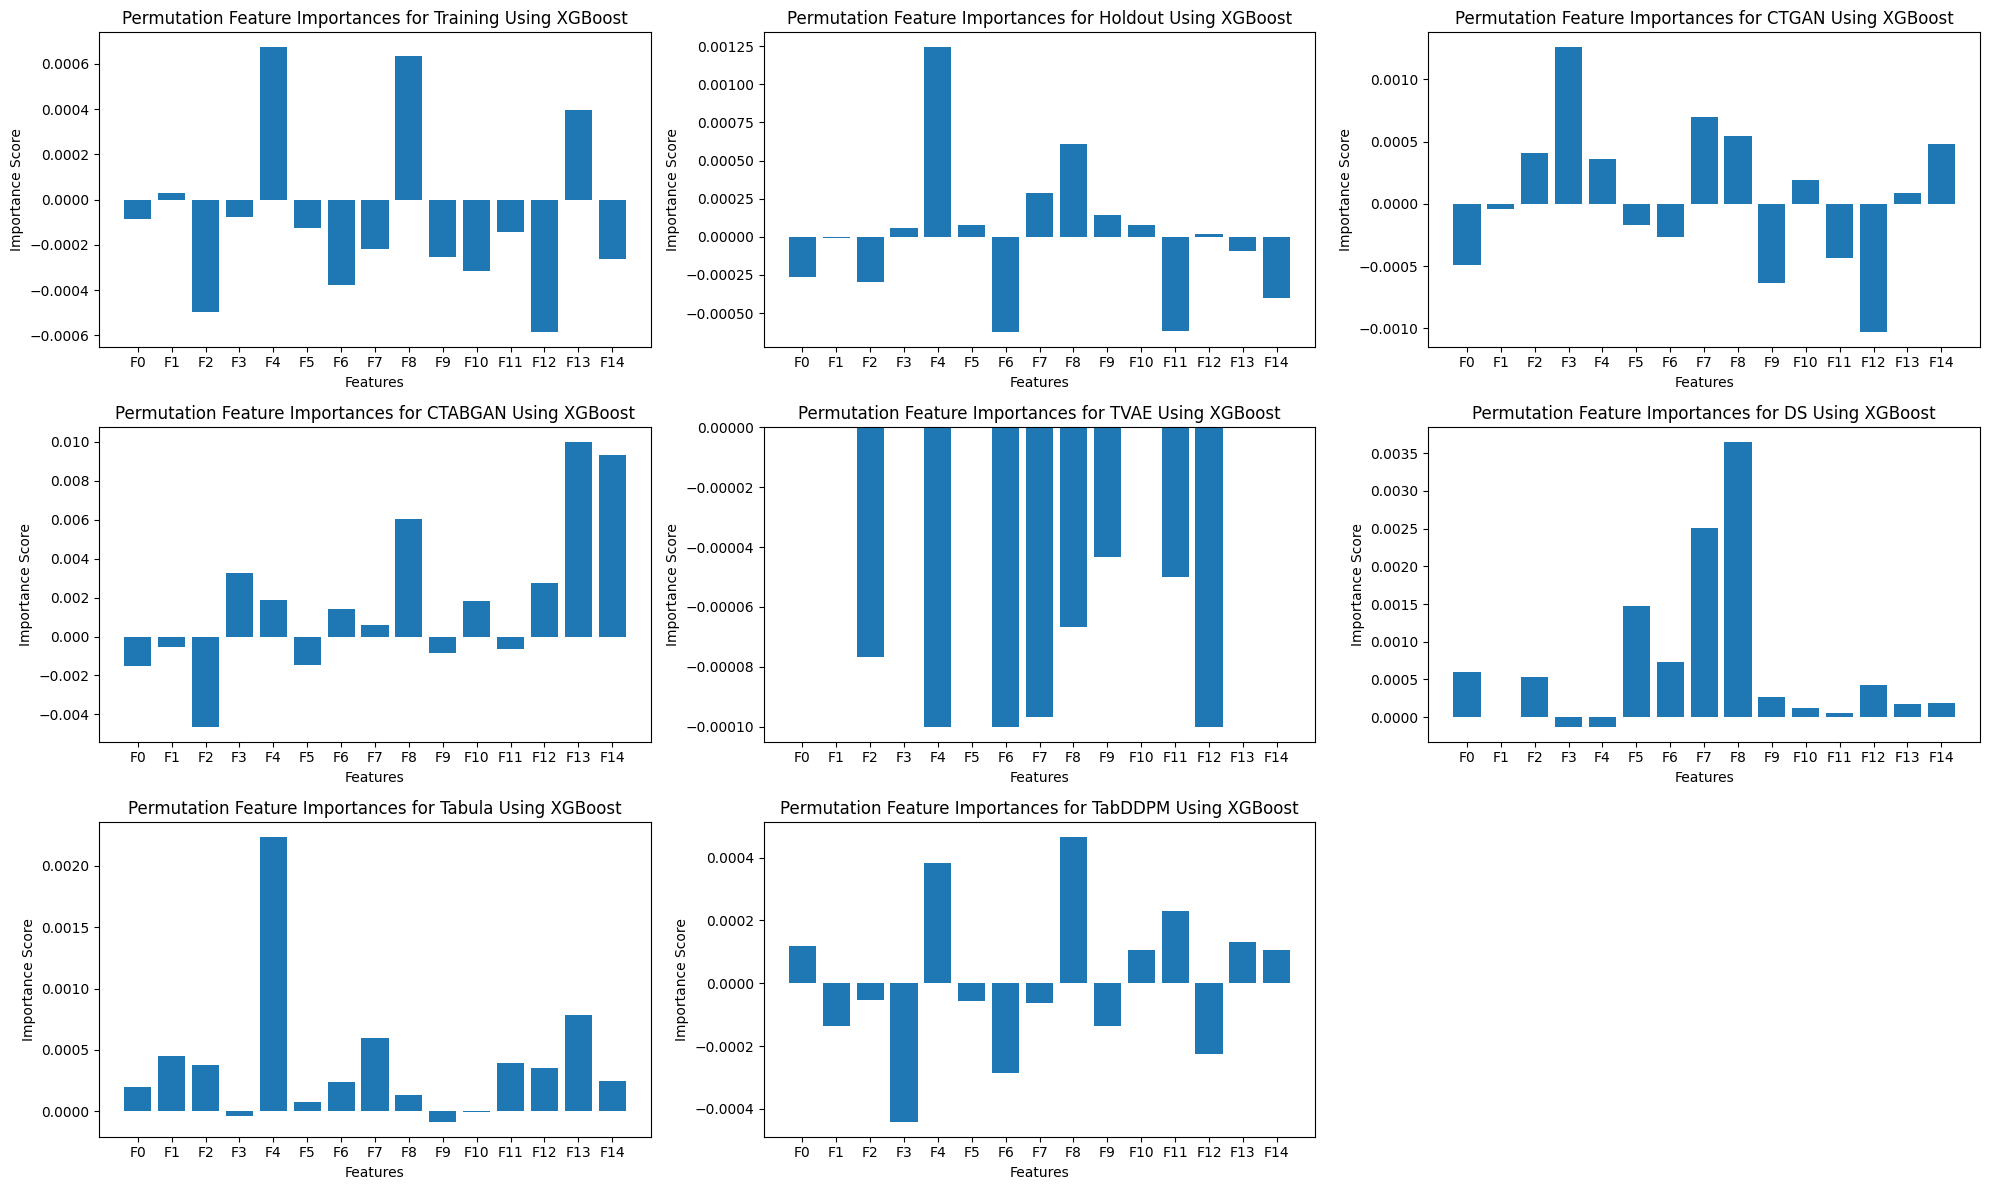

In [12]:
from sklearn.inspection import permutation_importance

fig, ax = plt.subplots(3, 3, figsize=(20, 12))
ax = ax.flatten()
for i, sample in enumerate(samples.keys()):
    importances = globals()[f'per_imp_{sample}_rf']
    ax[i].bar(features, importances.importances_mean)
    ax[i].set_title(f"Permutation Feature Importances for {sample} Using Random Forest")
    ax[i].set_xlabel("Features")
    ax[i].set_ylabel("Importance Score")
    
for j in range(len(samples.keys()), len(ax)):
    fig.delaxes(ax[j])
        
plt.tight_layout()
plt.show()
plt.close()


fig, ax = plt.subplots(3, 3, figsize=(20, 12))
ax = ax.flatten()
for i, sample in enumerate(samples.keys()):
    importances = globals()[f'per_imp_{sample}_xgb']
    ax[i].bar(features, importances.importances_mean)
    ax[i].set_title(f"Permutation Feature Importances for {sample} Using XGBoost")
    ax[i].set_xlabel("Features")
    ax[i].set_ylabel("Importance Score")
    
for j in range(len(samples.keys()), len(ax)):
    fig.delaxes(ax[j])
        
plt.tight_layout()
plt.show()
plt.close()

## SHAP Value

In [ ]:
import shap

fig, ax = plt.subplots(3, 3, figsize=(20, 12))
ax = ax.flatten()
for i, sample in enumerate(samples.keys()):
    importances = globals()[f'shap_imp_{sample}_rf']
    importances = np.mean(abs(importances.values), axis = 0)
    #shap.plots.bar(importances, show=False)
    ax[i].bar(features, importances)
    ax[i].set_title(f"Shap Valus for {sample} Using Random Forest")
    ax[i].set_xlabel("Features")
    ax[i].set_ylabel("Mean Absolute Shap Valus")
    
for j in range(len(samples.keys()), len(ax)):
    fig.delaxes(ax[j])
        
plt.tight_layout()
plt.show()
plt.close()

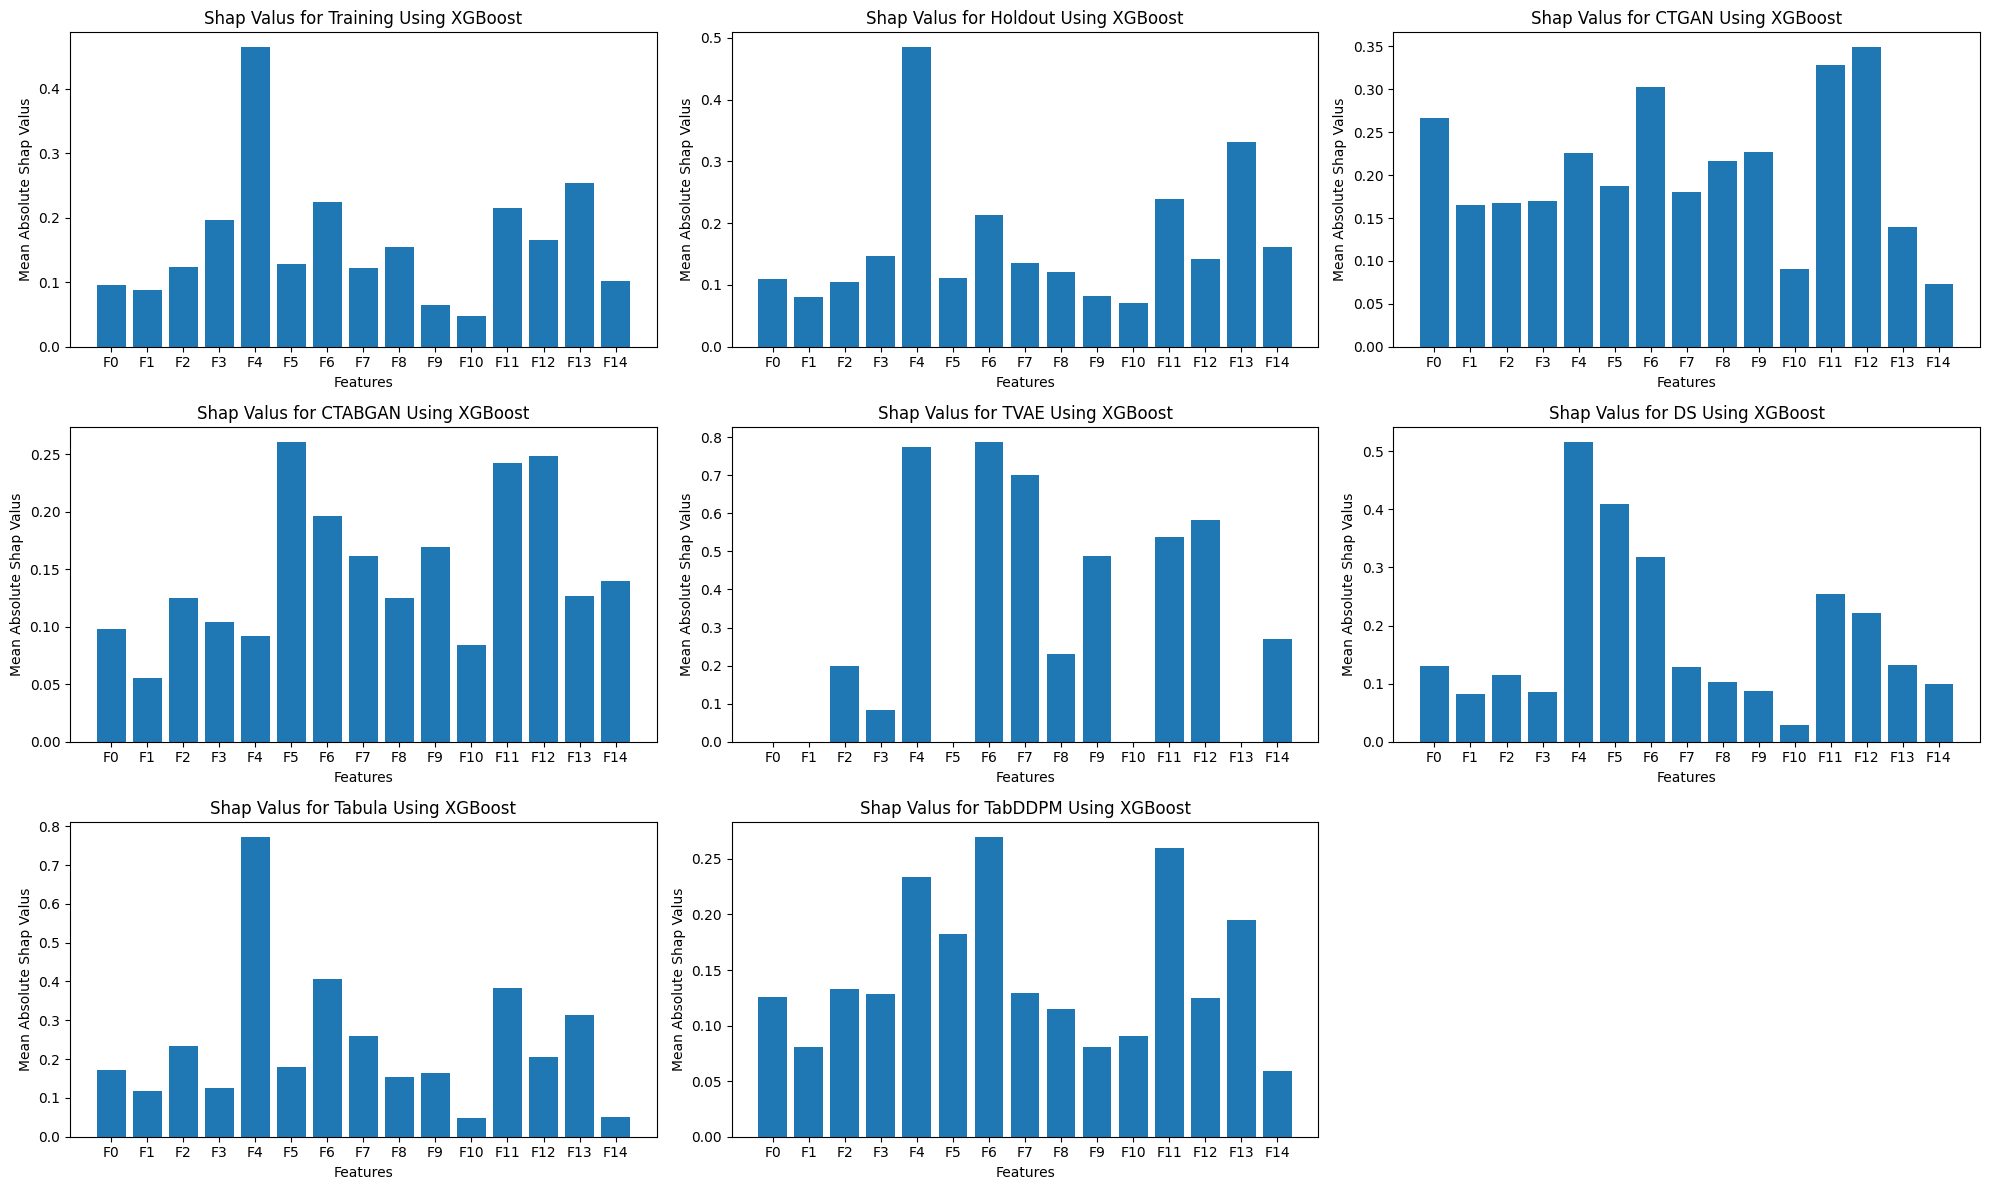

In [15]:
import numpy as np

fig, ax = plt.subplots(3, 3, figsize=(20, 12))
ax = ax.flatten()
for i, sample in enumerate(samples.keys()):
    importances = globals()[f'shap_imp_{sample}_xgb']
    importances = np.mean(abs(importances.values), axis = 0)
    #shap.plots.bar(importances, show=False)
    ax[i].bar(features, importances)
    ax[i].set_title(f"Shap Valus for {sample} Using XGBoost")
    ax[i].set_xlabel("Features")
    ax[i].set_ylabel("Mean Absolute Shap Valus")
    
for j in range(len(samples.keys()), len(ax)):
    fig.delaxes(ax[j])
        
plt.tight_layout()
plt.show()
plt.close()